In [4]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971, 20006114, 20006007, 20006618
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv('./dataset.csv')

# Drop unnamed and nulls
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert valence to binary: 0 = sad, 1 = happy
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1)

# Convert 'explicit' to int
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Define target and drop non-feature columns
y = df['valence']
X = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'valence', 'duration_ms'])

# Identify numeric features to scale
numeric_features = ['popularity', 'loudness', 'tempo']

# All other features (binary or one-hot) are left as-is
non_scaled_features = [col for col in X.columns if col not in numeric_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('pass', 'passthrough', non_scaled_features)
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(X_processed, columns=numeric_features + non_scaled_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)
X_processed

,popularity,loudness,tempo,explicit,danceability,energy,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,0.73,0.791392,0.361245,0,0.676,0.461,0,0.143,0.0322,0.000001,...,False,False,False,False,False,False,False,False,False,False
1,0.55,0.597377,0.318397,0,0.42,0.166,1,0.0763,0.924,0.000006,...,False,False,False,False,False,False,False,False,False,False
2,0.57,0.736123,0.313643,0,0.438,0.359,1,0.0557,0.21,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.71,0.573701,0.746758,0,0.266,0.0596,1,0.0363,0.905,0.000071,...,False,False,False,False,False,False,False,False,False,False
4,0.82,0.737103,0.492863,0,0.618,0.443,1,0.0526,0.469,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,0.21,0.612952,0.517705,0,0.172,0.235,1,0.0422,0.64,0.928,...,False,False,False,False,False,False,False,False,False,True
113995,0.22,0.577345,0.350242,0,0.174,0.117,0,0.0401,0.994,0.976,...,False,False,False,False,False,False,False,False,False,True
113996,0.22,0.714648,0.543933,0,0.629,0.329,0,0.042,0.867,0.0,...,False,False,False,False,False,False,False,False,False,True
113997,0.41,0.714759,0.558651,0,0.587,0.506,1,0.0297,0.381,0.0,...,False,False,False,False,False,False,False,False,False,True


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=8)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 85.68%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     18571
           1       0.85      0.83      0.84     15629

    accuracy                           0.86     34200
   macro avg       0.86      0.85      0.86     34200
weighted avg       0.86      0.86      0.86     34200

Confusion Matrix:
[[16317  2254]
 [ 2645 12984]]


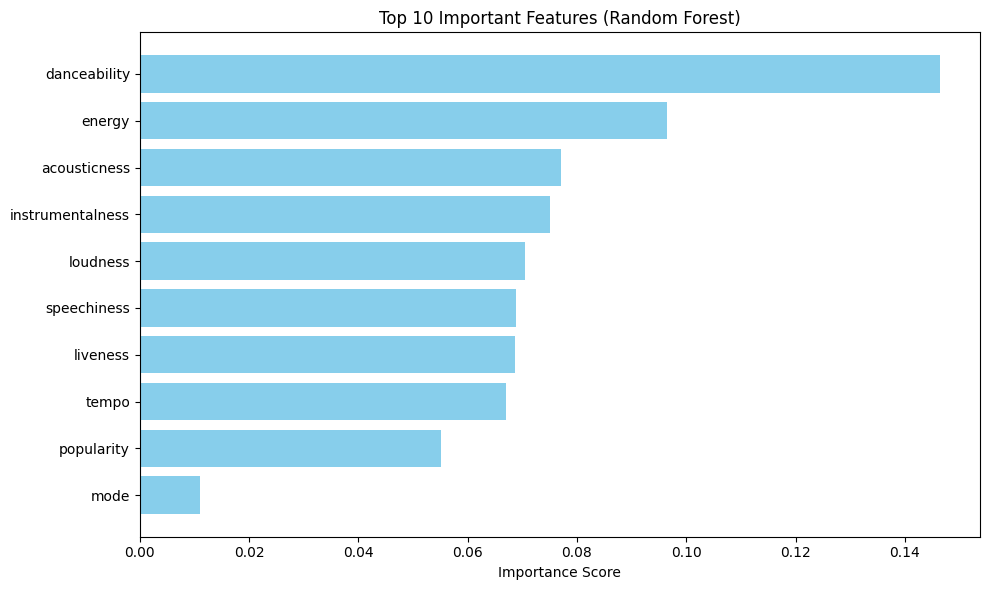

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances from the trained Random Forest model
importances = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance (descending) and select the top 10
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Important Features (Random Forest)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()
